# **WiDS DATATHON 2022**


In [ ]:
# import torch
# !pip install gpytorch

In [ ]:
# torch.cuda.is_available()
# z = torch.zeros(10).cuda()

## Dataset Download and Setup Steps:

1. Register into Kaggle account with gmail
2. Go into Rules section and click accept.
3. First download the [WiDS Kaggle's Dataset](https://www.kaggle.com/c/widsdatathon2022/data).
4. unzip the downloaded zip file locally. Mac double click on it, terminal use the unzip command. 
5. Then go to the "files" tab on the left side of the collab notebook. Go under "content" then drag locally extracted wids dataset directory and put it under "content". 

##Dataset Description

The Women in Data Science dataset consists of variables that describe building characteristics (e.g. floor area, facility type, etc.) and weather variables (e.g. annual average temperature, annual total precipitation, etc.) for the regions in which the buildings are located. This data was collected over 7 years and a number of states within the United States. 



Goal is to analyze the characteristics of the building and the weather data for the location of the building, creating models to predict building energy consumption (measured as Site Energy Usage Intensity).

##Imports

First lets import the modules we will use:

*   pandas
  *   Tool for analyzing, cleaning, exploring, and manipulating data.
*   matplotlib
  *   Plotting library.
*   seaborn
  *   Data visualization library. 
*   numpy
  *   Library for multidimensional array objects & high-level math functions.
*   scikit-learn
  *   Predictive data analysis tool.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import gpytorch

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from sklearn.ensemble import GradientBoostingRegressor

## Load Data

We will be using pandas to load and preprocess the data in "DataFrames".

In [ ]:
train_original = pd.read_csv('train.csv')
test_original = pd.read_csv('test.csv')

In [ ]:
print('Number of train samples are', train_original.shape)
print('Number of test samples are', test_original.shape)

## Data Pre-processing

### Label Encoding

We need to convert our categorical variables into numerical labels, AKA label encoding. Note: We will consider `year_built` as a categorical variable.

In [ ]:
categorical_features = ['State_Factor', 'building_class', 'facility_type', 'year_built']
le = LabelEncoder()

for feature in categorical_features:
    train_original[feature]= le.fit_transform(train_original[feature]).astype("uint8")
    test_original[feature]= le.fit_transform(test_original[feature]).astype("uint8")

### Missing Values

The data might be a little messy. Let's first check for missing values

Text(0.5, 1.0, 'Missing Values in Training Data')

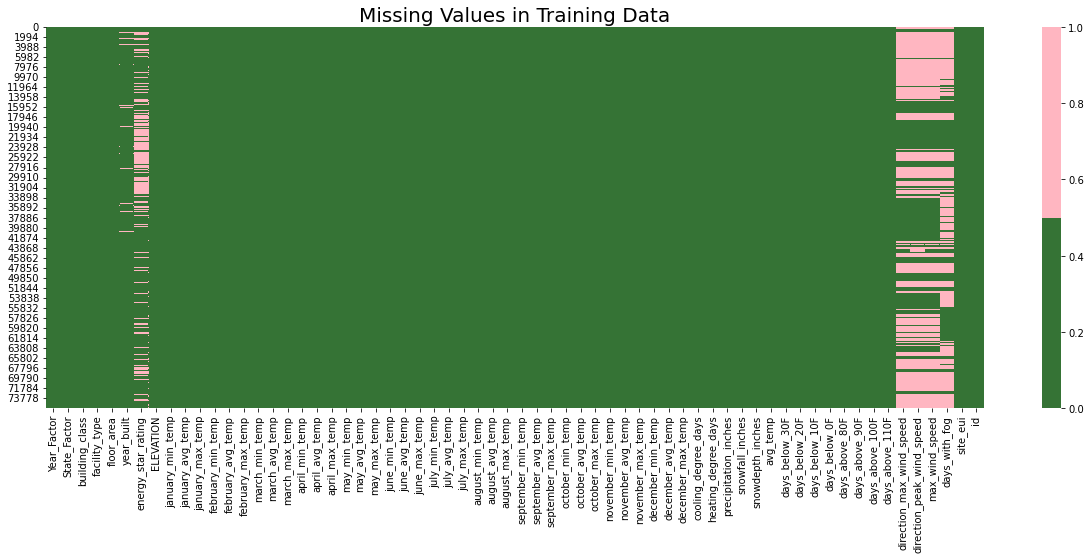

In [ ]:
plt.figure(figsize=(21,7))
sns.heatmap(train.isna().values, cmap = ['#357335','#ffb6c1'], xticklabels=train.columns)
plt.title("Missing Values in Training Data", size=20)

#### **Energy Star Rating**

First let's focus on imputing `energy_star_rating`. We split the data in order to fit a XGBoost model with all available `energy_star_ratings`. Then predict and replace values where `energy_star_rating` is missing for `train_original` and `test_original` datasets.

In [ ]:
# train contains ~35% missining values energy_star_rating
train_original[train_original['energy_star_rating'].isna()].shape[0]/(train_original.shape[0])

0.2606620732730857

In [ ]:
# test contains 18.8% missining values energy_star_rating
test_original[test_original['energy_star_rating'].isna()].shape[0]/(test_original.shape[0])

0.18847729743289574

In [ ]:
# set of energy_star_rating values that are present
train_avail_esr = train_original[~train_original['energy_star_rating'].isna()]
# test_avail_esr  = test_original[~test_original['energy_star_rating'].isna()]
# avail_esr = pd.concat([train_avail_esr,test_avail_esr], axis=0)

In [ ]:
# set of energy_star_rating values that are missing
train_unavail_esr = train_original[train_original['energy_star_rating'].isna()]
# test_unavail_esr = test_original[test_original['energy_star_rating'].isna()]

In [ ]:
cols_with_missing = ['site_eui']
for feature in cols_with_missing:
    mean = train_original[feature].mean()
    train_original[feature].fillna(mean, inplace=True)

In [ ]:
# Features
X = train_avail_esr.drop(['energy_star_rating'], axis=1)[['floor_area','year_built','State_Factor','building_class','facility_type','site_eui']]
# Labels
y = train_avail_esr['energy_star_rating']

In [ ]:
import xgboost
xgboost_model = xgboost.XGBRegressor(n_estimators=500, learning_rate=0.02, gamma=0, subsample=0.75,
                           colsample_bytree=0.4, max_depth=10)

In [ ]:
# fit model
xgboost_model.fit(X, y)

[21:54:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.4, learning_rate=0.02, max_depth=10,
             n_estimators=500, subsample=0.75)

In [ ]:
X_new = train_unavail_esr.drop(['energy_star_rating'], axis=1)[['floor_area','year_built','State_Factor','building_class','facility_type','site_eui']]

In [ ]:
# make a prediction
yhat = xgboost_model.predict(X_new)

In [ ]:
train_unavail_esr['energy_star_rating']=yhat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
recomputed = pd.concat([train_avail_esr, train_unavail_esr], axis=0)

In [ ]:
recomputed.shape

(75757, 64)

In [ ]:
train_original = recomputed

#### **Other Columns**

In [ ]:
cols_with_missing = [col for col in train_original.columns if train_original[col].isnull().any()]

miss_count = train_original.isna().sum()
miss_df = (pd.concat([miss_count.rename('Missing Count'), miss_count.div(len(train_original)).rename('Missing Value')], axis=1).loc[miss_count.ne(0)])
miss_df.style.background_gradient(cmap=sns.light_palette((351, 100, 86), input='husl', as_cmap=True))


,Missing Count,Missing Value
direction_max_wind_speed,41082,0.542287
direction_peak_wind_speed,41811,0.551909
max_wind_speed,41082,0.542287
days_with_fog,45796,0.604512


In [ ]:
for feature in cols_with_missing:
    mean = train_original[feature].mean()
    train_original[feature].fillna(mean, inplace=True)

### Add Seasons

In [ ]:
def temp_to_seasons(df):
    '''
    This function takes a dataframe and performs 3 tasks:
        1. Drop the min and max columns
        2. Converts the remaining into 4 seasons
        3. Drops the avg columns
    '''        
    # grouping in seasons
    df['spring'] = (df['march_avg_temp'] + df['april_avg_temp'] + df['may_avg_temp'])/3
    df['summer'] = (df['june_avg_temp'] + df['july_avg_temp'] + df['august_avg_temp'])/3
    df['autumn'] = (df['september_avg_temp'] + df['october_avg_temp'] + df['november_avg_temp'])/3
    df['winter'] = (df['december_avg_temp'] + df['january_avg_temp'] + df['february_avg_temp'])/3
  
    for i in df.columns:
        if '_avg' in i:
          df.drop(labels=i, axis=1, inplace=True)
        elif 'min_temp' in i:
          df.drop(labels=i, axis=1, inplace=True)
        elif 'max_temp' in i:
          df.drop(labels=i, axis=1, inplace=True)
    return df

In [ ]:
train_original = temp_to_seasons(train_original)
test_original = temp_to_seasons(test_original)

In [ ]:
list(train_original)

['Year_Factor',
 'State_Factor',
 'building_class',
 'facility_type',
 'floor_area',
 'year_built',
 'energy_star_rating',
 'ELEVATION',
 'cooling_degree_days',
 'heating_degree_days',
 'precipitation_inches',
 'snowfall_inches',
 'snowdepth_inches',
 'avg_temp',
 'days_below_30F',
 'days_below_20F',
 'days_below_10F',
 'days_below_0F',
 'days_above_80F',
 'days_above_90F',
 'days_above_100F',
 'days_above_110F',
 'direction_max_wind_speed',
 'direction_peak_wind_speed',
 'max_wind_speed',
 'days_with_fog',
 'site_eui',
 'id',
 'spring',
 'summer',
 'autumn',
 'winter']

### Add Floor Area Partition

In [ ]:
for i in range(1,8):
  if i == 7:
    print("Observation size for Year_Factor {}:\t".format(i),test_original.loc[test_original['Year_Factor']==i].shape[0])
  else:
    print("Observation size for Year_Factor {}:\t".format(i),train_original.loc[train_original['Year_Factor']==i].shape[0])

Observation size for Year_Factor 1:	 2117
Observation size for Year_Factor 2:	 9058
Observation size for Year_Factor 3:	 10879
Observation size for Year_Factor 4:	 12946
Observation size for Year_Factor 5:	 18308
Observation size for Year_Factor 6:	 22449
Observation size for Year_Factor 7:	 9705


In [ ]:
# create categories for floor area
train_original['floor_area_partition'] = pd.cut(train_original.floor_area,bins=np.exp([0,9,10,10.8,12,14,16]), labels=[0,1,2,3,4,5], right=False).values
test_original['floor_area_partition'] = pd.cut(test_original.floor_area,bins=np.exp([0,9,10,10.8,12,14,16]), labels=[0,1,2,3,4,5], right=False).values

In [ ]:
train_original['floor_area'] = np.log(train_original['floor_area'].values)
test_original['floor_area'] = np.log(test_original['floor_area'].values)

In [ ]:
# numerical_features = train.select_dtypes('number').columns
categorical_features = ['State_Factor', 'building_class', 'facility_type','floor_area_partition','year_built']
le = LabelEncoder()

for feature in categorical_features:
    train_original[feature]= le.fit_transform(train_original[feature]).astype("uint8")
    test_original[feature]= le.fit_transform(test_original[feature]).astype("uint8")

### Add Lag Features
Because we lag the features, we can only train on 2-6 Year_Factors

In [ ]:
train=train_original
ts_train = train[train['Year_Factor']>1]

Upsample each year_factor category, or dont

In [ ]:
max_size = ts_train['Year_Factor'].value_counts().max()
upstampled_X = [ts_train]
for class_index, group in ts_train.groupby('Year_Factor'):
    upstampled_X.append(group.sample(max_size-len(group), replace=True))
frame_new = pd.concat(upstampled_X)
# frame_new=ts_train

In [ ]:
for i in range(2,7):
  if i == 7:
    print("Observation size for Year_Factor {}:\t".format(i),test_original.loc[test_original['Year_Factor']==i].shape[0])
  else:
    print("Observation size for Year_Factor {}:\t".format(i),frame_new.loc[frame_new['Year_Factor']==i].shape[0])

Observation size for Year_Factor 2:	 22449
Observation size for Year_Factor 3:	 22449
Observation size for Year_Factor 4:	 22449
Observation size for Year_Factor 5:	 22449
Observation size for Year_Factor 6:	 22449


In [ ]:
def variable_lag1(df, column):
  mean_by_year = train_original.groupby(['Year_Factor']).mean()[column].values
  # create a vector to save the mean_differenced lag
  mean_diff_lag1 = []
  # print(mean_by_year)
  for idx,row in df.iterrows(): 
    year = row['Year_Factor']
    if year != 1:
      # subtract 1 for previous year, subtract 1 for python indexing
      mean_diff_lag1.append(row[column] - mean_by_year[int(year-1-1)])
    else:
      mean_diff_lag1.append(np.nan)
  new_column = 'lag1_{}'.format(column)
  df[new_column] = mean_diff_lag1

In [ ]:
variable_lag1(frame_new, 'summer')
variable_lag1(frame_new, 'spring')
variable_lag1(frame_new, 'autumn')
variable_lag1(frame_new, 'winter')
variable_lag1(frame_new, 'cooling_degree_days')
variable_lag1(frame_new, 'heating_degree_days')
variable_lag1(frame_new, 'precipitation_inches')
variable_lag1(frame_new, 'snowfall_inches')
variable_lag1(frame_new, 'days_below_20F')
variable_lag1(frame_new, 'days_above_100F')
variable_lag1(frame_new, 'energy_star_rating')
variable_lag1(frame_new, 'precipitation_inches')

In [ ]:
frame_new = frame_new.drop(['id'], axis=1)

In [ ]:
frame_new.shape

(112245, 43)

In [ ]:
full_features = list(frame_new)
if (len(full_features) % 2) != 0:
  full_features.append(" ")
it = iter(full_features)

for feature in it:
  print( '{:<40s} {:<40s}'.format(feature, next(it)) )

Year_Factor                              State_Factor                            
building_class                           facility_type                           
floor_area                               year_built                              
energy_star_rating                       ELEVATION                               
cooling_degree_days                      heating_degree_days                     
precipitation_inches                     snowfall_inches                         
snowdepth_inches                         avg_temp                                
days_below_30F                           days_below_20F                          
days_below_10F                           days_below_0F                           
days_above_80F                           days_above_90F                          
days_above_100F                          days_above_110F                         
direction_max_wind_speed                 direction_peak_wind_speed               
max_wind_speed  

# Train/test splits start here

In [ ]:
# Features
X = frame_new.drop(['site_eui'], axis=1)
submission_test = test_original.drop('id', axis = 1)
# Labels
y = frame_new['site_eui']


# Initial split to get training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# Second split to get validation and test set remove the val part we might not need it 
#X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [ ]:
X.head(20)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,...,lag1_spring,lag1_autumn,lag1_winter,lag1_cooling_degree_days,lag1_heating_degree_days,lag1_precipitation_inches,lag1_snowfall_inches,lag1_days_below_20F,lag1_days_above_100F,lag1_energy_star_rating
404,2,0,1,25,2.345567,77,100.0,2.4,791,2439,...,4.7567,2.77662,10.836735,-336.207841,-1662.316958,-43.879764,-36.908786,-9.127539,0.169107,35.808549
405,2,0,0,21,2.375244,78,61.0,2.4,791,2439,...,4.7567,2.77662,10.836735,-336.207841,-1662.316958,-43.879764,-36.908786,-9.127539,0.169107,-3.191451
406,2,0,0,21,2.484629,88,35.0,2.4,791,2439,...,4.7567,2.77662,10.836735,-336.207841,-1662.316958,-43.879764,-36.908786,-9.127539,0.169107,-29.191451
407,2,0,0,21,2.487546,91,74.0,2.4,791,2439,...,4.7567,2.77662,10.836735,-336.207841,-1662.316958,-43.879764,-36.908786,-9.127539,0.169107,9.808549
411,2,0,0,21,2.442597,93,98.0,2.4,791,2439,...,4.7567,2.77662,10.836735,-336.207841,-1662.316958,-43.879764,-36.908786,-9.127539,0.169107,33.808549
412,2,0,0,21,2.437709,77,80.0,2.4,791,2439,...,4.7567,2.77662,10.836735,-336.207841,-1662.316958,-43.879764,-36.908786,-9.127539,0.169107,15.808549
415,2,0,0,50,2.619134,110,67.0,2.4,791,2439,...,4.7567,2.77662,10.836735,-336.207841,-1662.316958,-43.879764,-36.908786,-9.127539,0.169107,2.808549
416,2,0,0,32,2.364281,71,95.0,2.4,791,2439,...,4.7567,2.77662,10.836735,-336.207841,-1662.316958,-43.879764,-36.908786,-9.127539,0.169107,30.808549
417,2,0,0,32,2.383192,72,87.0,2.4,791,2439,...,4.7567,2.77662,10.836735,-336.207841,-1662.316958,-43.879764,-36.908786,-9.127539,0.169107,22.808549
418,2,0,0,21,2.456094,72,59.0,2.4,791,2439,...,4.7567,2.77662,10.836735,-336.207841,-1662.316958,-43.879764,-36.908786,-9.127539,0.169107,-5.191451


# Test with different predictors

In [ ]:
# predictors = ['State_Factor','floor_area_partition', 'energy_star_rating','year_built', 'ELEVATION', 'building_class', \
#               'lag1_days_below_20F', 'lag1_days_above_100F', 'lag1_summer', 'lag1_winter']
predictors = [x for x in list(X) if x != "Year_Factor"]

# Subsetting on our predictors

In [ ]:
# Pick our feature and reshape the data so it works with the model
X_train_reshape = X_train[predictors]
X_test_reshape = X_test[predictors]
  

In [ ]:
full_features = list(X_train_reshape)
if (len(full_features) % 2) != 0:
  full_features.append(" ")
it = iter(full_features)

for feature in it:
  print( '{:<40s} {:<40s}'.format(feature, next(it)) )

State_Factor                             building_class                          
facility_type                            floor_area                              
year_built                               energy_star_rating                      
ELEVATION                                cooling_degree_days                     
heating_degree_days                      precipitation_inches                    
snowfall_inches                          snowdepth_inches                        
avg_temp                                 days_below_30F                          
days_below_20F                           days_below_10F                          
days_below_0F                            days_above_80F                          
days_above_90F                           days_above_100F                         
days_above_110F                          direction_max_wind_speed                
direction_peak_wind_speed                max_wind_speed                          
days_with_fog   

In [ ]:
X_train_reshape.head(5)

,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,...,lag1_spring,lag1_autumn,lag1_winter,lag1_cooling_degree_days,lag1_heating_degree_days,lag1_precipitation_inches,lag1_snowfall_inches,lag1_days_below_20F,lag1_days_above_100F,lag1_energy_star_rating
22778,5,1,27,2.444162,105,80.304916,42.7,1277,3978,38.51,...,2.927847,-2.896319,1.217899,149.792159,-123.316958,-24.639764,-27.308786,-4.127539,-0.830893,16.113465
2651,0,0,2,2.519929,138,60.824299,120.4,497,1477,20.69,...,8.065997,7.805679,18.650462,-690.158470,-3018.729479,-21.375227,-24.373840,-10.755400,-0.405092,2.774515
18285,5,1,27,2.539716,144,58.925980,15.2,1277,3978,38.51,...,2.927847,-2.896319,1.217899,149.792159,-123.316958,-24.639764,-27.308786,-4.127539,-0.830893,-5.265471
23285,5,1,27,2.419974,118,81.393410,42.7,1277,3978,38.51,...,2.927847,-2.896319,1.217899,149.792159,-123.316958,-24.639764,-27.308786,-4.127539,-0.830893,17.201959
38217,5,0,32,2.575788,91,79.000000,42.7,1128,4875,53.79,...,-1.474505,0.461593,-3.357602,-59.158470,379.270521,11.724773,25.626160,13.244600,-0.405092,20.950216


# Reduce the feature space by importance

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
# get all possible interactions
poly = PolynomialFeatures(interaction_only=True, include_bias = False)
X_all_train_interactions = poly.fit_transform(X_train_reshape)

In [ ]:
# make it a dataframe
X_interactions_train_df = pd.DataFrame(X_all_train_interactions,
                   columns=poly.get_feature_names(X_train_reshape.columns))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_interactions_train_df.shape

(89796, 861)

In [ ]:
# repeat for test set
poly = PolynomialFeatures(interaction_only=True, include_bias = False)
X_all_interactions_test = poly.fit_transform(X_test_reshape)

In [ ]:
X_interactions_test_df = pd.DataFrame(X_all_interactions_test,
                   columns=poly.get_feature_names(X_test_reshape.columns))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_interactions_train_df.head()

,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,...,lag1_precipitation_inches lag1_snowfall_inches,lag1_precipitation_inches lag1_days_below_20F,lag1_precipitation_inches lag1_days_above_100F,lag1_precipitation_inches lag1_energy_star_rating,lag1_snowfall_inches lag1_days_below_20F,lag1_snowfall_inches lag1_days_above_100F,lag1_snowfall_inches lag1_energy_star_rating,lag1_days_below_20F lag1_days_above_100F,lag1_days_below_20F lag1_energy_star_rating,lag1_days_above_100F lag1_energy_star_rating
0,5.0,1.0,27.0,2.444162,105.0,80.304916,42.7,1277.0,3978.0,38.51,...,672.882038,101.701585,20.473002,-397.031980,112.718079,22.690673,-440.039177,3.429542,-66.508956,-13.388562
1,0.0,0.0,2.0,2.519929,138.0,60.824299,120.4,497.0,1477.0,20.69,...,520.996342,229.899119,8.658941,-59.305891,262.150401,9.873657,-67.625588,4.356931,-29.841022,-1.123935
2,5.0,1.0,27.0,2.539716,144.0,58.925980,15.2,1277.0,3978.0,38.51,...,672.882038,101.701585,20.473002,129.739972,112.718079,22.690673,143.793632,3.429542,21.733438,4.375042
3,5.0,1.0,27.0,2.419974,118.0,81.393410,42.7,1277.0,3978.0,38.51,...,672.882038,101.701585,20.473002,-423.852199,112.718079,22.690673,-469.764609,3.429542,-71.001755,-14.292983
4,5.0,0.0,32.0,2.575788,91.0,79.000000,42.7,1128.0,4875.0,53.79,...,300.460925,155.289930,-4.749616,245.636540,339.408237,-10.380962,536.873606,-5.365286,277.477229,-8.486773


# LGB top N features

In [ ]:
import lightgbm as lgb
fit_params = {"early_stopping_rounds":100, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(X_interactions_test_df,y_test)],
            'eval_names': ['valid'],
            'verbose': 1000,
           }

                                # n_estimators=3000,
                                # reg_lambda=3.8446449556043025,
                                # colsample_bytree=0.40,
                                # subsample=0.65,
                                # min_child_samples = 43,
                                # learning_rate = 0.025,
                                # num_leaves=262
lgb_model = lgb.LGBMRegressor (n_estimators = 5000,
                                max_depth = 11,
                                num_leaves = 15,
                                learning_rate = 0.01,
                                subsample = 0.9,
                                colsample_bytree = 0.7,
                                random_state = 42 )
lgb_model.fit(X_interactions_train_df, y_train, **fit_params)
predictions = lgb_model.predict(X_interactions_test_df)

Training until validation scores don't improve for 100 rounds.
[1000]	valid's l2: 1198.07	valid's rmse: 34.6132
[2000]	valid's l2: 1101.26	valid's rmse: 33.1852
[3000]	valid's l2: 1038.21	valid's rmse: 32.2213
[4000]	valid's l2: 991.412	valid's rmse: 31.4867
[5000]	valid's l2: 952.508	valid's rmse: 30.8627
Did not meet early stopping. Best iteration is:
[5000]	valid's l2: 952.508	valid's rmse: 30.8627


In [ ]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
print(f'The Mean Square Error is {rmse}')
mydf = pd.DataFrame(list(zip(list(X_interactions_train_df), lgb_model.feature_importances_)), columns = ['Feature', 'Importance'])


The Mean Square Error is 30.862729068452442


In [ ]:
top_features = mydf.sort_values('Importance', ascending=False).head(50)

In [ ]:
full_features = list(top_features['Feature'])
if (len(full_features) % 2) != 0:
  full_features.append(" ")
it = iter(full_features)

for feature in it:
  print( '{:<40s} {:<40s}'.format(feature, next(it)) )

floor_area                               facility_type                           
facility_type year_built                 facility_type floor_area                
facility_type energy_star_rating         facility_type lag1_energy_star_rating   
floor_area year_built                    State_Factor floor_area                 
energy_star_rating lag1_energy_star_rating year_built lag1_energy_star_rating      
year_built                               year_built energy_star_rating           
building_class floor_area                energy_star_rating ELEVATION            
floor_area days_with_fog                 year_built ELEVATION                    
floor_area autumn                        State_Factor year_built                 
facility_type ELEVATION                  State_Factor energy_star_rating         
building_class year_built                year_built days_with_fog                
energy_star_rating                       State_Factor lag1_energy_star_rating    
floor_area ELE

In [ ]:
top_features['Feature']

3                                       floor_area
2                                    facility_type
121                       facility_type year_built
120                       facility_type floor_area
122               facility_type energy_star_rating
157          facility_type lag1_energy_star_rating
158                          floor_area year_built
43                         State_Factor floor_area
265     energy_star_rating lag1_energy_star_rating
230             year_built lag1_energy_star_rating
4                                       year_built
195                  year_built energy_star_rating
82                       building_class floor_area
231                   energy_star_rating ELEVATION
178                       floor_area days_with_fog
196                           year_built ELEVATION
181                              floor_area autumn
44                         State_Factor year_built
123                        facility_type ELEVATION
45                 State_Factor

In [ ]:
top_features.Feature.values.tolist()

['floor_area',
 'facility_type',
 'facility_type year_built',
 'facility_type floor_area',
 'facility_type energy_star_rating',
 'facility_type lag1_energy_star_rating',
 'floor_area year_built',
 'State_Factor floor_area',
 'energy_star_rating lag1_energy_star_rating',
 'year_built lag1_energy_star_rating',
 'year_built',
 'year_built energy_star_rating',
 'building_class floor_area',
 'energy_star_rating ELEVATION',
 'floor_area days_with_fog',
 'year_built ELEVATION',
 'floor_area autumn',
 'State_Factor year_built',
 'facility_type ELEVATION',
 'State_Factor energy_star_rating',
 'building_class year_built',
 'year_built days_with_fog',
 'energy_star_rating',
 'State_Factor lag1_energy_star_rating',
 'floor_area ELEVATION',
 'floor_area spring',
 'facility_type summer',
 'floor_area direction_max_wind_speed',
 'floor_area avg_temp',
 'floor_area summer',
 'State_Factor facility_type',
 'facility_type days_with_fog',
 'floor_area energy_star_rating',
 'year_built days_above_80F',
 '

In [ ]:
# import xgboost as xgb
# regressor = xgb.XGBRegressor(
#     n_estimators=250,
#     reg_alpha= 1.029841665079736703,
#     reg_lambda=3.8446449556043025,
#     colsample_bytree=0.40,
#     subsample=0.65,
#     min_child_samples = 43,
#     learning_rate = 0.025,
#     num_leaves=262
# )
# regressor.fit(X_interactions_train_df, y_train)


[00:48:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.4, learning_rate=0.025, min_child_samples=43,
             n_estimators=250, num_leaves=262, reg_alpha=1.0298416650797366,
             reg_lambda=3.8446449556043025, subsample=0.65)

In [ ]:
# predictions = regressor.predict(X_interactions_test_df)
# rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
# print(f'The Mean Square Error is {rmse}')
# mydf = pd.DataFrame(list(zip(list(X_interactions_train_df), regressor.feature_importances_)), columns = ['Feature', 'Importance'])


The Mean Square Error is 38.87356511944638


In [ ]:
# Get statistically significant features
X_train_adjusted = X_interactions_train_df[top_features.Feature.values.tolist()]
X_test_adjusted = X_interactions_test_df[top_features.Feature.values.tolist()]


# Pick our feature and reshape the data so it works with the model
# X_train_adjusted = X_train[predictors]
# X_test_adjusted = X_test[predictors]

In [ ]:
X_train_adjusted.head(10)

,floor_area,facility_type,facility_type year_built,facility_type floor_area,facility_type energy_star_rating,facility_type lag1_energy_star_rating,floor_area year_built,State_Factor floor_area,energy_star_rating lag1_energy_star_rating,year_built lag1_energy_star_rating,...,facility_type avg_temp,facility_type heating_degree_days,facility_type direction_max_wind_speed,lag1_spring lag1_energy_star_rating,energy_star_rating direction_max_wind_speed,facility_type winter,facility_type autumn,year_built summer,floor_area lag1_energy_star_rating,energy_star_rating lag1_days_above_100F
0,2.444162,27.0,2835.0,65.992380,2168.232742,435.063564,256.637034,12.220811,1293.990487,1691.913861,...,1548.885246,107406.0,27.000000,47.177768,80.304916,1077.026696,1536.435484,7925.223118,39.383923,-66.724775
1,2.519929,2.0,276.0,5.039858,121.648598,5.549030,347.750211,0.000000,168.757941,382.883096,...,124.134247,2954.0,133.105350,22.379231,4048.019784,111.174731,131.129749,9115.790323,6.991581,-24.639460
2,2.539716,27.0,3888.0,68.572344,1591.001450,-142.167728,365.719170,12.698582,-310.273062,-758.227885,...,1548.885246,107406.0,1796.922221,-15.416497,3921.681561,1077.026696,1536.435484,10868.877420,-13.372804,-48.961171
3,2.419974,27.0,3186.0,65.339302,2197.622063,464.452885,285.556951,12.099871,1400.126072,2029.831126,...,1548.885246,107406.0,27.000000,50.364711,81.393410,1077.026696,1536.435484,8906.441219,41.628296,-67.629196
4,2.575788,32.0,2912.0,82.425219,2528.000000,670.406923,234.396716,12.878940,1655.067090,1906.469686,...,1744.043836,156000.0,32.000000,-30.891198,79.000000,1074.537634,1863.065233,6767.709140,53.963318,-32.002298
5,2.443753,27.0,3483.0,65.981331,27.000000,-1540.344159,315.244139,7.331259,-57.049784,-7359.422093,...,1475.595506,128520.0,1796.922221,18.675111,66.552675,924.727189,1545.416010,9634.866666,-139.415581,-0.405092
6,2.393413,27.0,1998.0,64.622154,1560.606056,-172.563122,177.112570,11.967066,-369.414339,-472.950778,...,1548.885246,107406.0,27.000000,-18.712537,57.800224,1077.026696,1536.435484,5585.395341,-15.296846,-48.025789
7,2.537206,58.0,5046.0,147.157972,5147.910202,1857.147626,220.736957,12.686032,2841.982524,2785.721439,...,3296.465754,258680.0,19140.000000,38.361566,29289.833908,2021.792243,3582.113262,6639.300538,81.240808,-18.085985
8,2.412000,32.0,5216.0,77.183998,2624.000000,808.406855,393.155988,4.824000,2071.542565,4117.822415,...,1782.180822,119744.0,2129.685595,36.948596,5457.319337,1463.213518,1732.266667,11214.721326,60.933665,-16.709099
9,2.397539,27.0,2835.0,64.733553,1755.000000,223.093283,251.741596,11.987695,537.076423,867.584991,...,1534.561644,120420.0,9720.000000,9.899212,23400.000000,941.179147,1667.535484,8012.948925,19.810180,-13.245018


# Linear Regression on reduced important features

In [ ]:
# Instantiate the model
linear_regression_model = LinearRegression() 

# Fit model to training data
linear_regression_model.fit(X_train_adjusted, y_train)

LinearRegression()

In [ ]:
predictions = linear_regression_model.predict(X_test_adjusted)


In [ ]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
print(f'The Mean Square Error is {rmse}')

The Mean Square Error is 45.09199532022846


# LASSO CV

In [ ]:
#from sklearn.linear_model import LassoCV
#reg = LassoCV(cv=5, random_state=0).fit(X_train_adjusted, y_train)


In [ ]:
#predictions = reg.predict(X_test_adjusted)

In [ ]:
#rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
#print(f'The Mean Square Error is {rmse}')

The Mean Square Error is 47.27165664097512


# XGBoost

In [ ]:
# import xgboost as xgb
# regressor = xgb.XGBRegressor(
#     n_estimators=3000,
#     reg_lambda=3.8446449556043025,
#     colsample_bytree=0.40,
#     subsample=0.65,
#     min_child_samples = 43,
#     learning_rate = 0.025,
#     num_leaves=262
# )
# regressor.fit(X_train_adjusted, y_train)

# mydf = pd.DataFrame(list(zip(list(X_train_adjusted), regressor.feature_importances_)), columns = ['Feature', 'Importance'])
# mydf.sort_values('Importance', ascending=False).head(15)

In [ ]:
# predictions = regressor.predict(X_test_adjusted)
# rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
# print(f'The Mean Square Error is {rmse}')

# Light GBM?

In [ ]:
import lightgbm as lgb
fit_params = {"early_stopping_rounds":100, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(X_test_adjusted,y_test)],
            'eval_names': ['valid'],
            'verbose': 1000,
           }
lgb_model_1 = lgb.LGBMRegressor (n_estimators = 40000,
                                max_depth = 11,
                                num_leaves = 15,
                                learning_rate = 0.025,
                                subsample = 0.9,
                                colsample_bytree = 0.7,
                                random_state = 42 )
lgb_model_1.fit(X_train_adjusted, y_train, **fit_params)
predictions_1 = lgb_model_1.predict(X_test_adjusted)

Training until validation scores don't improve for 100 rounds.
[1000]	valid's l2: 1041.68	valid's rmse: 32.2751
[2000]	valid's l2: 901.756	valid's rmse: 30.0293
[3000]	valid's l2: 830.817	valid's rmse: 28.8239
[4000]	valid's l2: 783.753	valid's rmse: 27.9956
[5000]	valid's l2: 751.596	valid's rmse: 27.4152
[6000]	valid's l2: 727.1	valid's rmse: 26.9648
[7000]	valid's l2: 709.009	valid's rmse: 26.6272
[8000]	valid's l2: 691.663	valid's rmse: 26.2995
[9000]	valid's l2: 678.795	valid's rmse: 26.0537
[10000]	valid's l2: 666.044	valid's rmse: 25.8078
[11000]	valid's l2: 655.359	valid's rmse: 25.6
[12000]	valid's l2: 646.896	valid's rmse: 25.4342
[13000]	valid's l2: 638.323	valid's rmse: 25.2651
[14000]	valid's l2: 631.034	valid's rmse: 25.1204
[15000]	valid's l2: 624.625	valid's rmse: 24.9925
[16000]	valid's l2: 618.653	valid's rmse: 24.8727
[17000]	valid's l2: 613.591	valid's rmse: 24.7708
[18000]	valid's l2: 608.791	valid's rmse: 24.6737
[19000]	valid's l2: 603.449	valid's rmse: 24.5652
[

In [ ]:
for y, y_pred in list(zip(y_test, predictions_1))[:5]:
    print('Real value: {:.3f} Estimated value: {:.5f}'.format(y, y_pred))
rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions_1))
print(f'The Mean Squared Error is {rmse}')